In [1]:
source('function.r')

Warning message:
“package ‘pheatmap’ was built under R version 4.1.3”


In [15]:
library(Seurat)

Warning message:
“package ‘Seurat’ was built under R version 4.1.2”
Attaching SeuratObject



In [2]:
# read raw data downloaded from orignal paper
RAW <- read.csv(file='./data/CROP-seq_Jurkat_TCR.digital_expression.500genes.only_assigned.csv',header=TRUE,row.names=1)

In [3]:
# it contains the basic information of experimental data
RAW[1:6,1:6]

,stimulated,stimulated.1,stimulated.2,stimulated.3,stimulated.4,stimulated.5
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
replicate,1,1,1,1,1,1
cell,TACTTGACCCCN,TTACAGCTGAAC,CTAAGGCCCTTA,CTTGACGCAGGT,TAACCCGTACGC,ATCTAGATACNN
grna,CTRL00320,Tcrlibrary_JUND_2,Tcrlibrary_BACH2_3,Tcrlibrary_NFKB2_3,Tcrlibrary_JUN_1,CTRL00696
gene,CTRL,JUND,BACH2,NFKB2,JUN,CTRL
GENE,,,,,,
A1BG,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
# split perturbed data and only extract stimulated

Y.stimulated.raw <- RAW[,grepl('^stimulated', colnames(RAW))]
colnames(Y.stimulated.raw) <- as.character(unlist(RAW['cell',grepl('^stimulated', colnames(RAW))]))

# the name of sgRNA
Y.stimulated.sgRNA <- as.character(unlist(RAW['gene',grepl('^stimulated', colnames(RAW))]))

# Y: cells*genes
Y.stimulated <- t(Y.stimulated.raw[6:dim(Y.stimulated.raw)[1],])

cat("dimension of Y.stimulated(include control):", dim(Y.stimulated),'\n')


dimension of Y.stimulated(include control): 3259 36722 


In [5]:
# saveRDS(Z.unstimulated,'data/Z.unstimulated.rds')

In [7]:
# stimulated part design matrix
# design matrix X stores the information of cell-gRNA relationship
sgRNAs <- (unique(Y.stimulated.sgRNA))

i <- 1
for(s in sgRNAs){
    X_design.stimulated[which(Y.stimulated.sgRNA == s), i] <- 1
    i <- i+1
}
rownames(X_design.stimulated) <- rownames(Y.stimulated)
colnames(X_design.stimulated) <- sgRNAs

In [10]:
# extract the control group, only select the stimulate group
Z.stimulated <- Y.stimulated[which(X_design.stimulated$CTRL==1),]

In [11]:
# saveRDS(Z.stimulated,'data/Z.stimulated.rds')

In [13]:
colSums(X_design.stimulated)

CTRL   JUND  BACH2  NFKB2    JUN  NFKB1   JUNB  GATA3 NFATC1   RELA   ETS1 
   705    110    118     75     87    156    107     44    146     62     28 
 RUNX2  RUNX1    FOS   RELB    LCK  ZAP70   EGR3   EGR1   DOK2 PTPN11  DHODH 
   105     29    131     97     49     83     55    134    105     82     20 
 NR4A1  PTPN6   EGR2  NFAT5   EGR4   TUBB    REL    MVD NFATC3 NFATC2    LAT 
    90     87     77     52     60      7    100     28     85     71     74

# Seurat processing control cells Z

## normalized data

In [16]:
Z.seurat <- CreateSeuratObject(counts = t(Z.stimulated), min.cells = 0, min.features = 0)

Z.seurat

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
36722 features across 705 samples within 1 assay 
Active assay: RNA (36722 features, 0 variable features)

In [17]:
Z.seurat <- NormalizeData(Z.seurat)

all.genes <- rownames(Z.seurat)
Z.seurat <- ScaleData(Z.seurat, features = all.genes)

Centering and scaling data matrix



## Only High Variable Genes

In [18]:
Z.seurat <- FindVariableFeatures(Z.seurat, selection.method = "vst", nfeatures = 600)

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.8734”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.50234”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  4.4038e-16”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 0.090619”


When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 12457 rows containing missing values (geom_point).”


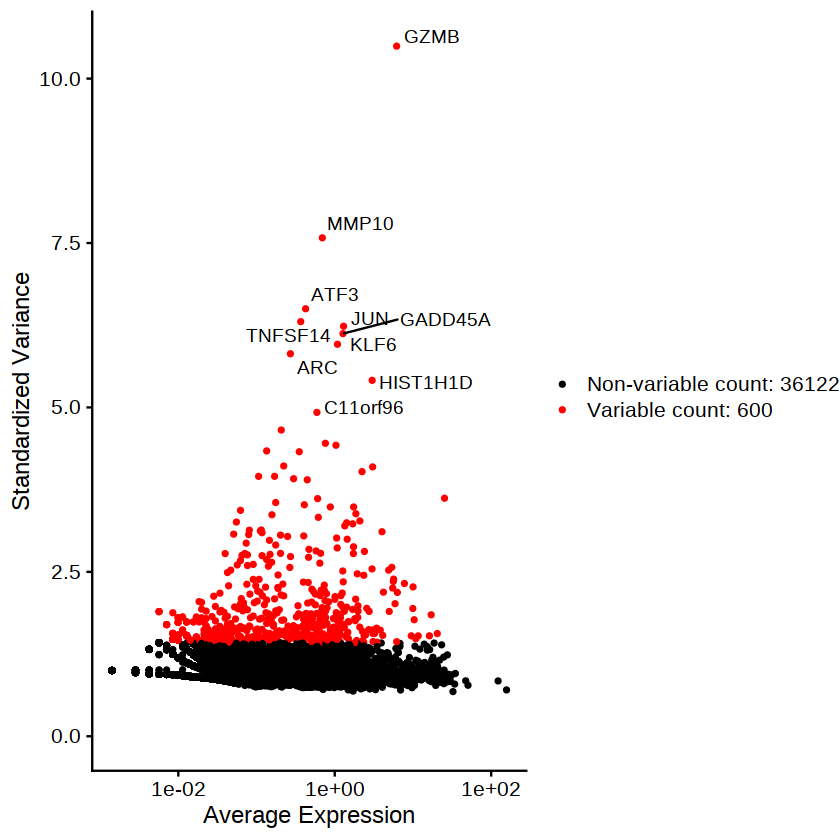

In [19]:
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(Z.seurat), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(Z.seurat)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot2

In [20]:
CROP_variable_genes <- VariableFeatures(Z.seurat)

## Save all variables

In [21]:
Y.stimulated <- apply(Y.stimulated,c(1,2),as.numeric)
Z.stimulated <- apply(Z.stimulated, c(1,2), as.numeric)

In [22]:
save(CROP_variable_genes,X_design.stimulated,Y.stimulated,Z.stimulated,file='data/variables_fromPreprocessing.image')